In [1]:
import numpy as np
from datetime import date

from pulse2percept import electrode2currentmap as e2cm
from pulse2percept import effectivecurrent2brightness as ec2b
from pulse2percept.utils import TimeSeries

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def setup_model(exp_params):
    model = dict()
    
    # set up temporal model
    model['tm'] = ec2b.TemporalModel(model=exp_params['model'],
                                     tsample=exp_params['tsample'])

    # Electrode locations for patient TB (in microns), from MATLAB script
    x_elec_loc = np.array([-6825.092215, -6332.563035, -5840.033855, -5347.504675,
                           -6194.683612, -5702.154432, -5209.625252, -4717.096072,
                           -5564.275010, -5071.745829, -4579.216649, -4086.687469,
                           -4933.866407, -4441.337226, -3948.808046, -3456.278866])
    y_elec_loc = np.array([-655.666769, -25.258166, 605.150437, 1235.559040,
                           -1148.195949, -517.787346, 112.621257, 743.029860,
                           -1640.725129, -1010.316526, -379.907924, 250.500679,
                           -2133.254310, -1502.845707, -872.437104, -242.028501])

    # MATLAB had the OD at (0,0), we have it at (15,2) deg
    x_elec_loc += e2cm.deg2micron(15)
    y_elec_loc += e2cm.deg2micron(2)
    
    # Radii (almost) alternating to create checkerboard pattern
    r_arr = np.array([260, 520, 260, 520])
    r_arr = np.concatenate((r_arr, r_arr[::-1], r_arr, r_arr[::-1]), axis=0)
    
    # Set electrode height to something realistic
    h_arr = np.ones(16)*100

    model['implant'] = e2cm.ElectrodeArray(r_arr.tolist(), x_elec_loc.tolist(),
                                           y_elec_loc.tolist(), h_arr.tolist())

    # find x,y limits from electrode location
    round_to_nearest = 200.0  # microns
    x_min = np.floor((x_elec_loc.min() - 500.0) / round_to_nearest) * round_to_nearest
    x_max = np.ceil((x_elec_loc.max() + 500.0) / round_to_nearest) * round_to_nearest
    y_min = np.floor((y_elec_loc.min() - 500.0) / round_to_nearest) * round_to_nearest
    y_max = np.ceil((y_elec_loc.max() + 500.0) / round_to_nearest) * round_to_nearest

    r_sampling = 250  # spatial sampling of the retina
    r_file = '../retina_argusI_s%d_%dx%d.npz' % (r_sampling, x_max - x_min, y_max - y_min)
    model['retina'] = e2cm.Retina(axon_map=r_file, sampling=r_sampling,
                                  xlo=x_min, xhi=x_max, ylo=y_min, yhi=y_max)
    
    # We derive the effective current stimulation (ecs; passed through the effect of
    # the retinal layout, axons, etc.) in addition to the current (cs):
    model['integrationtype'] = 'dotproduct'
    model['ecs'], model['cs'] = model['retina'].electrode_ecs(model['implant'],
                                                              integrationtype=model['integrationtype'])
    
    return model

In [3]:
def run_trial(amp_E1, amp_E2, freq_E1, freq_E2, exp_params, model):
    idx_E1 = exp_params['idx_E1']
    idx_E2 = exp_params['idx_E2']
    
    # generate list of pulse trains
    pt_list = []
    for j in range(16):
        if j == idx_E1:
            pt_list.append(get_pulse_train(amp_E1, freq_E1, tsample=exp_params['tsample']))
        elif j == idx_E2:
            pt_list.append(get_pulse_train(amp_E2, freq_E2, tsample=exp_params['tsample']))
        else:
            # all others zero
            pt_list.append(get_pulse_train(0, 0, tsample=exp_params['tsample']))
            
    # Calculate response
    if exp_params['use_ecs']:
        current_spread = model['ecs']
    else:
        current_spread = model['cs']
    resp = ec2b.pulse2percept(model['tm'], current_spread, model['retina'],
                              pt_list, 30, dojit=False, n_jobs=1)

    # Find brightest element
    idx_px = resp.data.argmax()
    
    # Find frame where brightest pixel is: unravel maps flat index onto
    # high-dimensional indices (x,y,z). What we want is index z (the frame index).
    idx_frame = np.unravel_index(idx_px, resp.shape)[-1]
    
    # return that single frame
    return resp.data[..., idx_frame]

In [4]:
def run_experiment(exp_params, model):
    print('Experiment: %s (%s, %s)' % (exp_params['name'],
                                       exp_params['name_E1'],
                                       exp_params['name_E2']))

    exp_params['date'] = date.today().strftime("%Y-%m-%d")
    # Generate filename and make sure we can write to it
    # Do this now rather than after hours of number crunching...
    filename = '%s%s_E%d_E%d_%s.npz' % (exp_params['save_dir'],
                                        exp_params['name'],
                                        exp_params['idx_E1'],
                                        exp_params['idx_E2'],
                                        exp_params['date'])
    exp_params['filename'] = filename
    np.savez(filename, data=np.zeros(10))

    # Sample the range of meaningful amplitudes/frequencies
    numDataPoints = 5
    exp_params['amp_range'] = np.linspace(0, 80, numDataPoints)
    exp_params['freq_range'] = np.linspace(0, 180, numDataPoints)
    
    data = dict()
    data['amp_E1'] = []
    data['amp_E2'] = []
    data['freq_E1'] = []
    data['freq_E2'] = []
    data['frames'] = []
    for amp_E1 in exp_params['amp_range']:
        for amp_E2 in exp_params['amp_range']:
            for freq_E1 in exp_params['freq_range']:
                for freq_E2 in exp_params['freq_range']:
                    data['amp_E1'].append(amp_E1)
                    data['amp_E2'].append(amp_E2)
                    data['freq_E1'].append(freq_E1)
                    data['freq_E2'].append(freq_E2)
                    data['frames'].append(run_trial(amp_E1, amp_E2, freq_E1, freq_E2,
                                                    exp_params, model))

    # Save results to .npz
    np.savez(filename, data=data, exp_params=exp_params, model=model)
    print('- Results saved to %s' % filename)

In [5]:
# We could use ec2b.Psycho2Pulsetrain, but we'd like to have the stimulus first, 
# followed by the inter-pulse gap. ec2b.Psycho2Pulsetrain has the inter-pulse
# gap first...
def get_pulse_train(ampl, freq, delay_dur=0, tsample=5e-6):
    pulse_dur = 0.45/1000
    stim_dur = 0.5
    stim_size = int(np.round(stim_dur / tsample))
    
    if freq == 0:
        # avoid division by zero
        pulse_train = np.zeros(stim_size)
        return TimeSeries(tsample, pulse_train)

    # envelope size (single pulse + gap) given by `freq`
    envelope_size = int(np.round((1/freq) / tsample))

    # delay given by `delay_dur`
    delay_size = int(np.round(delay_dur / tsample))
    delay = np.zeros(delay_size)

    # single pulse given by `pulse_dur`
    pulse = ampl * e2cm.get_pulse(pulse_dur, tsample, pulse_dur, 'cathodicfirst')
    pulse_size = pulse.size

    # then gap is used to fill up what's left
    gap_size = envelope_size - delay_size - pulse_size
    gap = np.zeros(gap_size)

    pulse_train = []
    for j in range(int(np.round(stim_dur * freq))):
        pulse_train = np.concatenate((pulse_train, delay, pulse, gap), axis=0)
        
    if pulse_train.size < stim_size:
        filler_size = stim_size - pulse_train.size
        filler = np.zeros(filler_size)
        pulse_train = np.concatenate((pulse_train, filler), axis=0)
        
    if pulse_train.size > stim_size:
        pulse_train = pulse_train[:stim_size]
    
    return TimeSeries(tsample, pulse_train)

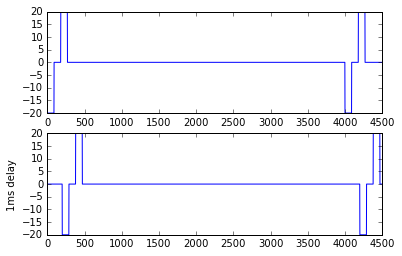

In [6]:
plt.subplot(211)
plt.plot(get_pulse_train(20, 50, 0).data[0:4500])

plt.subplot(212)
plt.plot(get_pulse_train(20, 50, 1/1000).data[0:4500])
plt.ylabel('1ms delay')

In [ ]:
exp_params = dict()

# give the experiment a name
exp_params['name'] = 'inverse'

# where to save the data (relative path)
exp_params['save_dir'] = 'data/inverse/'

# sampling step in seconds
exp_params['tsample'] = 5e-6

# model flavor
exp_params['model'] = 'Nanduri'

# whether to use effective current map (True) or current map (False)
exp_params['use_ecs'] = True

model = setup_model(exp_params)

In [ ]:
indices = np.arange(16)
names = ['A1','B1','C1','D1','A2','B2','C2','D2','A3','B3','C3','D3','A4','B4','C4','D4']

for i in range(16):
    exp_params['idx_E1'] = i
    exp_params['name_E1'] = names[i]
    if i == 0:
        continue
    
    for j in range(i + 1, 16):
        if i == 1 and j < 11:
            continue
        exp_params['idx_E2'] = j
        exp_params['name_E2'] = names[j]
        
        t_exe = %timeit -oq -n1 -r1 run_experiment(exp_params, model)
        print('- Experiment took %.1f s' % t_exe.best)

Experiment: inverse (B1, D3)
